In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
#from sympy import *
from scipy import special
from numba import njit, prange


# Definición de constantes y Malla

In [2]:
#define las constantes necesarias
k1 = 0.85
k2 = 0.8
ph1 = np.pi*5./4.
ph2 = np.pi/4.

#constantes del fondo a z=0

OmCDM=0.3153
OmB = 0.
OmK = 0.
OmL = 1.-OmB-OmCDM-OmK
H0 = 67.36 #km/(s*Mpc)
c = 299792.458 #km/s


#constantes del fondo a z=23 (para probar el codigo)

z=1100.


Hini = np.sqrt(H0**2*((OmCDM+OmB)*(1+z)**3 + OmL)) #km/(s*Mpc)

print('Hini = ',Hini)

OmLin = OmL*(H0/Hini)**2. 
OmM = 1.-OmLin 
OmCDMin = OmM*(OmCDM/(OmB + OmCDM))
OmBin = OmM*(OmB/(OmB + OmCDM))
OmK = 0.

Gyr = 31557600000000000. # en s
Mpc = 3.08567758128*10**(19) # en km
Hinis = Hini/Mpc # H inicial en 1/segundos
H0s = H0/Mpc*Gyr # H0 en 1/segundos de hecho en Gyr
HinisG = Hinis*Gyr

#calculo del tiempo inicial y final para tener el Dt = t0 - ti de evolución del distema
az = 1/(1+z)
t0 = 2./(3.*H0s*np.sqrt(OmL))*np.arcsinh(np.sqrt(OmL/OmCDM))
ti = 2./(3.*H0s*np.sqrt(OmL))*np.arcsinh(np.sqrt(az**3.*OmL/OmCDM))

dti = t0-ti
Dt0 = (t0-ti)* Gyr #13.809 * Gyr #calculado para z = 1100
Dtau0 = Dt0*Hinis # tiempo adimensional

l = 0.0025 #*Mpc # escala característica

L = c/(Hini)

print('az= ',az)
print('ti= ',ti)
print('t0= ',t0)
print('dti= ',dti)
print('Dt0= ',Dt0)
print('Dtau0 = ',Dtau0)
print('H0s = ', H0s)
print('tH0 = ', 1./(H0s*Gyr))
print('l = ', l)
print('OmCDMin = ', OmCDMin)
print('OmLin = ', OmLin)
print('OmL = ', OmL)
print('L (Mpc)= ', L)
print('OM = ', OmB+OmCDM)
print('OmL = ', OmL)


Hini =  1381799.536515684
az=  0.0009082652134423251
ti=  0.0004717482270063152
t0=  13.800724694153427
dti=  13.80025294592642
Dt0=  4.355028623663676e+17
Dtau0 =  19502.285560226006
H0s =  0.06888989144219693
tH0 =  4.599816772917592e-16
l =  0.0025
OmCDMin =  0.9999999983728994
OmLin =  1.627100578538509e-09
OmL =  0.6847
L (Mpc)=  0.21695799577118846
OM =  0.3153
OmL =  0.6847


In [3]:
#define la malla radial
n=1000
n1=int(n/1.7449)#n/2)
r0=0.
rn1 = 3.
#rn=6.
#h=(rn-r0)/float(n)
#r=[]
#for i in range(0,n+1):
 #   b = r0 + float(i*h)
  #  r.append(b)
r1 = np.linspace(r0,10.7376*l,n)
h = (r1[-1]-r1[0])/n
    

#define la malla angular

m=100
#ph0=0.
#phn=2.*np.pi
#hp=(phn-ph0)/float(m)
#ph=[]
#for i in range(0,m+1):
 #   bp = ph0 + float(i*hp)
  #  ph.append(bp)
ph = np.linspace(0.,2*np.pi,m)
hp = (ph[-1]-ph[0])/m

#s=11
#s1 = int((s-1)/2) 
#th0=0.
#thn=np.pi
#hth=(thn-th0)/float(s)
#th=[]
#for i in range(0,m+1):
 #   bt = th0 + float(i*hth)
  #  th.append(bt)
#th = np.linspace(0.,np.pi,s)
#hth = (th[-1]-th[0])/n

nt = 1000
tspan = np.array([0., Dtau0])
times = np.linspace(tspan[0],tspan[1],nt)
ht = times[1]-times[0]

print(h)
print(hp)
#print(hth)
print(ht)

print('r1(n1)=',r1[n1])

print('r_1=',r1[n1])
print('r_2=',r1[-1])
len(r1)
#print(th[s1])
#print(len(th))

np.pi/2

2.6844000000000003e-05
0.06283185307179587
19.5218073675936
r1(n1)= 0.015397009009009012
r_1= 0.015397009009009012
r_2= 0.026844000000000003


1.5707963267948966

In [4]:
@njit(parallel=True)
def SistEcs1(y,t):
    #y = np.zeros(8*(n+1))
    Omq = y[::6]
    Hq = y[1::6]
    Dm = y[2::6]
    Dh = y[3::6]
    a = y[4::6]
    G = y[5::6]
    
    dydt = np.empty_like(y)
    dOmqdt = dydt[::6]
    dHqdt = dydt[1::6]
    dDmdt = dydt[2::6]
    dDhdt = dydt[3::6]
    dadt = dydt[4::6]
    dGdt = dydt[5::6]

    dOmqdt[0] = -3.*Omq[0]*Hq[0]
    dHqdt[0] = -Hq[0]**2.-Omq[0]+OmLin
    dDmdt[0] = 0.
    dDhdt[0] = 0
    dadt[0] = a[0]*Hq[0]
    dGdt[0] = 0
    
    for i in prange(1, n1):
        dOmqdt[i] = -3.*Omq[i]*Hq[i]
        dHqdt[i] = -Hq[i]**2.-Omq[i]+OmLin
        dDmdt[i] = -3.*Dm[i]*Hq[i]-3.*(Dm[i]+Omq[i])*Dh[i]
        dDhdt[i] = -(2.*Hq[i]+3.*Dh[i])*Dh[i]-Dm[i]
        dadt[i] = a[i]*Hq[i]
        dGdt[i] = 3.*G[i]*Dh[i]
    return dydt

In [5]:
@njit(parallel=True)
def SistEcs2(y,t):
    #y = np.zeros(8*(n+1))
    Omq = y[::6]
    Hq = y[1::6]
    Dm = y[2::6]
    Dh = y[3::6]
    a = y[4::6]
    G = y[5::6]
    
    dydt = np.empty_like(y)
    dOmqdt = dydt[::6]
    dHqdt = dydt[1::6]
    dDmdt = dydt[2::6]
    dDhdt = dydt[3::6]
    dadt = dydt[4::6]
    dGdt = dydt[5::6]
    
    for i in prange(0, n-n1):
        dOmqdt[i] = -3.*Omq[i]*Hq[i]
        dHqdt[i] = -Hq[i]**2.-Omq[i]+OmLin
        dDmdt[i] = -3.*Dm[i]*Hq[i]-3.*(Dm[i]+Omq[i])*Dh[i]
        dDhdt[i] = -(2.*Hq[i]+3.*Dh[i])*Dh[i]-Dm[i]
        dadt[i] = a[i]*Hq[i]
        dGdt[i] = 3.*G[i]*Dh[i]
    return dydt

In [6]:
#a0 = 0.497
#a1 = 0.
#a2 = 0.
#a3 = 0.000126429
#a4 = -0.0000306754
#a5 = 1.98474*10.**(-6.)

#b0 = -0.0014
#b1 = 0.
#b2 = 0.
#b3 = 0.00005496
#b4 = -0.0000133349
#b5 = 8.62789*10.**(-7.)

#c0 = 0.498929
#c1 = 0.000688877
#c2 = -0.000175584
#c3 = 0.0000218361
#c4 = -1.32251*10.**(-6.)
#c5 = 3.12653*10.**(-8.)

#d0 = -0.00555285
#d1 = 0.00354957
#d2 = -0.000904728
#d3 = 0.000112514
#d4 = -6.8145*10.**(-6.)
#d5 = 1.61101*10.**(-7.)

In [7]:
#a0 = 0.497
#a1 = 0.
#a2 = 0.
#a3 = 0.00009508944472
#a4 = -0.00002307154552
#a5 = 1.492759339*10.**(-6.)

#b0 = -0.0014
#b1 = 0.
#b2 = 0.
#b3 = 0.00005496
#b4 = -0.0000133349
#b5 = 8.62789*10.**(-7.)

#c0 = 0.4815300659
#c1 = 0.01153572695
#c2 = -0.002940271898
#c3 = 0.0003656603467
#c4 =-0.00002214641344
#c5 = 5.235603812*10.**(-7.)

#d0 = -0.00555285
#d1 = 0.00354957
#d2 = -0.000904728
#d3 = 0.000112514
#d4 = -6.8145*10.**(-6.)
#d5 = 1.61101*10.**(-7.)

In [8]:
a0 = 0.4999000000
a1 = 0.
a2 = 0.
a3 = 136.2002116
a4 = -13218.49924
a5 = 342101.7147

b0 = -0.001400000000
b1 = 0.
b2 = 0.
b3 = 1901.039759
b4 = -184499.6592
b5 = 4.774948246*10.**(6.)

c0 = 0.4964475936
c1 = 0.9122672546
c2 = -93.00891952
c3 = 4626.738560
c4 = -112088.3516
c5 = 1.059946242*10.**(6.)

d0 = -0.02735609765
d1 = 6.942999202
d2 = -707.8636778
d3 = 35212.75368
d4 = -853071.6536
d5 = 8.066940774*10.**(6.)

(3.0, 6.0)

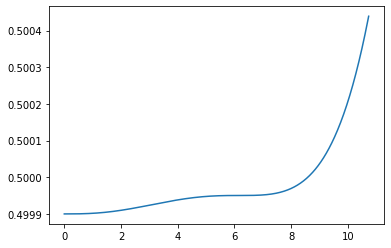

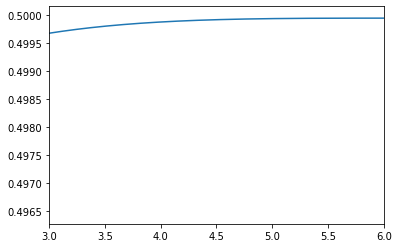

In [9]:
def Q1(r):
    Q1 = a0+a1*r+a2*r**2.+a3*r**3.+a4*r**4.+a5*r**5.
    return Q1

def P1(r):
    P1 = b0+b1*r+b2*r**2.+b3*r**3.+b4*r**4.+b5*r**5.
    return P1

def Q2(r):
    Q2 = c0+c1*r+c2*r**2.+c3*r**3.+c4*r**4.+c5*r**5.
    return Q2

def P2(r):
    P2 = d0+d1*r+d2*r**2.+d3*r**3.+d4*r**4.+d5*r**5.
    return P2

def dQ1(r):
    dQ1 = a1+2.*a2*r+3.*a3*r**2.+4.*a4*r**3.+5.*a5*r**4.
    return dQ1

def dP1(r):
    dP1 = b1+2.*b2*r+3.*b3*r**2.+4.*b4*r**3.+5.*b5*r**4.
    return dP1

def dQ2(r):
    dQ2 = c1+2.*c2*r+3.*c3*r**2.+4.*c4*r**3.+5.*c5*r**4.
    return dQ2

def dP2(r):
    dP2 = d1+2.*d2*r+3.*d3*r**2.+4.*d4*r**3.+5.*d5*r**4.
    return dP2

def f1(r):
    f1 = np.sin((r-r1[0])*np.pi/(r1[n1]-r1[0]))**2.
    return f1

def f2(r):
    f2 = np.sin((r-r1[n1])*np.pi/(r1[-1]-r1[n1]))**2.
    return f2

def X1(r):
    X1 = -np.cos(ph1)*k1*f1(r)
    return X1

def Y1(r):
    Y1 = -np.sin(ph1)*k1*f1(r)
    return Y1

def X2(r):
    X2 = -np.cos(ph2)*k2*f2(r)
    return X2

def Y2(r):
    Y2 = -np.sin(ph2)*k2*f2(r)
    return Y2

def M(r):
    M = 0.5-0.003/(1.+(r/r1[n1])**3.)
    return M

def dM(r):
    dM = 0.009*r**2./(1.+r**3.)**2
    return dM

def KK(r):
    KK = -0.0014/(1.+(r/r1[n1])**(7./5.))
    return KK

def dKK(r):
    dKK = -0.00196*r**(2./5.)/(1.+r**(7./5.))**2.
    return dKK

plt.figure(1)
plt.plot(r1/l,Q1(r1))
#plt.plot(r1/l,M(r1))
axes = plt.gca()
#axes.set_xlim([0,6])
#axes.set_ylim([0.496,0.502])

plt.figure(2)
plt.plot(r1/l,Q2(r1))
#plt.plot(r1/l,M(r1))
axes = plt.gca()
axes.set_xlim([3,6])
#axes.set_ylim([0.496,0.502])

In [10]:
fa = np.zeros((6*n1,m))

Omq0a = fa[::6,::1]
Hq0a = fa[1::6,::1]
Dm0a = fa[2::6,::1]
Dh0a = fa[3::6,::1]
a0a = fa[4::6,::1]
G0a = fa[5::6,::1]

Kq0a = np.zeros((n1,m))
W0a = np.zeros((n1,m))

for i in range(0, n1):
        for j in range(0,m):
            W0a[i,j] = -X1(r1[i])*np.sin(np.pi/2)*np.cos(ph[j])-Y1(r1[i])*np.sin(np.pi/2)*np.sin(ph[j])
            Kq0a[i,j] = P1(r1[i])
            Omq0a[i,j] = Q1(r1[i])
            Hq0a[i,j] = np.sqrt(2.*Q1(r1[i])+OmLin-P1(r1[i])) 
            Dm0a[i,j] = r1[i]*dQ1(r1[i])/(3.-3.*W0a[i,j])
            Dh0a[i,j] = (2.*Dm0a[i,j]-r1[i]*dP1(r1[i])/(3.-3.*W0a[i,j]))/(2.*Hq0a[i,j])
            a0a[i,j] = 1.
            G0a[i,j] = 1.#-W0a[i,j]

fb = np.zeros((6*(n-n1),m))

Omq0b = fb[::6,::1]
Hq0b = fb[1::6,::1]
Dm0b = fb[2::6,::1]
Dh0b = fb[3::6,::1]
a0b = fb[4::6,::1]
G0b = fb[5::6,::1]

Kq0b = np.zeros((n1,m))
W0b = np.zeros((n1,m))                

for i in range(0, n-n1):
        for j in range(0,m):
            W0b[i,j] = -X2(r1[i+n1])*np.sin(np.pi/2)*np.cos(ph[j])-Y2(r1[i+n1])*np.sin(np.pi/2)*np.sin(ph[j])
            Kq0b[i,j] = P2(r1[i+n1])
            Omq0b[i,j] = Q2(r1[i+n1])
            Hq0b[i,j] = np.sqrt(2.*Q2(r1[i+n1])+OmLin-P2(r1[i+n1])) 
            Dm0b[i,j] = r1[i+n1]*dQ2(r1[i+n1])/(3.-3.*W0b[i,j])
            Dh0b[i,j] = (2.*Dm0b[i,j]-r1[i+n1]*dP2(r1[i+n1])/(3.-3.*W0b[i,j]))/(2.*Hq0b[i,j])
            a0b[i,j] = 1.
            G0b[i,j] = 1.#-W0b[i,j]
                
#print(G0b)

In [11]:
a0a[:,0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [12]:
WSol = np.zeros((n,m))

for i in range(0,n1):
    WSol[i,:] = W0a[i,:]
    
for i in range(0,n-n1):
    WSol[i+n1,:] = W0b[i,:]

In [13]:
#se obtiene la solucion del sistema

#sola = np.zeros((6*n1,m,len(times)))

#for j in range(0,m):
 #   sola1 = solve_ivp(SistEcs1, tspan, fa[:,j], method='RK45',t_eval=times)
  #  for o in range(len(times)):
   #     for g in range(0,6*n1):
    #        sola[g,j,o] = sola1.y[g,o]
        
        
#sola = odeintw(SistEcs1, fa, times,Dfun=None)
#sola

In [14]:
#se obtiene la solucion del sistema


sola = np.zeros((len(times),6*n1,m))

for j in prange(0,m):
    sola1 = odeint(SistEcs1,fa[:,j],times)
    for o in prange(len(times)):
        for g in prange(0,6*n1):
            sola[o,g,j] = sola1[o,g]
        
        
#sola = odeintw(SistEcs1, fa, times,Dfun=None)
sola

array([[[ 4.99900000e-01,  4.99900000e-01,  4.99900000e-01, ...,
          4.99900000e-01,  4.99900000e-01,  4.99900000e-01],
        [ 1.00059982e+00,  1.00059982e+00,  1.00059982e+00, ...,
          1.00059982e+00,  1.00059982e+00,  1.00059982e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-9.04534267e-08, -9.04533263e-08, -9.04532329e-08, ...,
         -9.04536467e-08, -9.04535336e-08, -9.04534267e-08],
        [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
          1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
        [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
          1.00000000e+00,  1.00000000e+00,  1.00000000e+00]],

       [[ 5.40817837e-04,  5.40817837e-04,  5.40817837e-04, ...,
          5.40817837e-04,  5.40817837e-04,  5.40817837e-04],
        [ 3.31119331e-02,  3.31119331e-02,  3.31119331e-02, ...,
          3.31119331e-02,  3.31119331e

In [15]:
#se obtiene la solucion del sistema

solb = np.zeros((len(times),6*(n-n1),m))

for j in prange(0,m):
    solb1 = odeint(SistEcs2,fb[:,j],times)
    for o in prange(len(times)):
        for g in prange(0,6*(n-n1)):
            solb[o,g,j] = solb1[o,g]
        
        
#sola = odeintw(SistEcs1, fa, times,Dfun=None)
solb

array([[[ 4.99950285e-01,  4.99950285e-01,  4.99950285e-01, ...,
          4.99950285e-01,  4.99950285e-01,  4.99950285e-01],
        [ 1.00029931e+00,  1.00029931e+00,  1.00029931e+00, ...,
          1.00029931e+00,  1.00029931e+00,  1.00029931e+00],
        [ 1.22491443e-08,  1.22491443e-08,  1.22491443e-08, ...,
          1.22491443e-08,  1.22491443e-08,  1.22491443e-08],
        ...,
        [-5.41035633e-11, -5.41035633e-11, -5.41035633e-11, ...,
         -5.41035633e-11, -5.41035633e-11, -5.41035633e-11],
        [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
          1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
        [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
          1.00000000e+00,  1.00000000e+00,  1.00000000e+00]],

       [[ 5.43021341e-04,  5.43021341e-04,  5.43021341e-04, ...,
          5.43021341e-04,  5.43021341e-04,  5.43021341e-04],
        [ 3.30670535e-02,  3.30670535e-02,  3.30670535e-02, ...,
          3.30670535e-02,  3.30670535e

In [16]:
np.size(sola[0,0,0])

1

In [17]:
#se define una matriz de la longitud del numero de pasos temporales en la integracion por el 
#numero de componentes de la maya

OmqSol=np.zeros((len(times),n,m)) 

#se le da a este arreglo de comer las entradas de la solucion tal que cada renglon sea
# la solucion de Y en la maya 

for k in prange(0, len(times), 1):
    for i in prange(0, n1):
        for j in prange(0,m):
            OmqSol[k,0,0] = sola[k,0,0]
            OmqSol[k,i,j] = sola[k,i*6,j] 
                
for k in prange(0, len(times), 1):
    for i in prange(0, (n-n1)):
        for j in prange(0,m):
            OmqSol[k,n1,0] = solb[k,0,0]
            OmqSol[k,i+n1,j] = solb[k,i*6,j] 

HqSol=np.zeros((len(times),n,m))  

#se le da a este arreglo de comer las entradas de la solucion tal que cada renglon sea
# la solucion de Kq en la maya 

for k in prange(0, len(times), 1):
    for i in prange(0, n1):
        for j in prange(0,m):
            HqSol[k,0,0] = sola[k,1,0]
            HqSol[k,i,j] = sola[k,(i*6)+1,j]  
                
for k in range(0, len(times), 1):
    for i in range(0, (n-n1)):
        for j in range(0,m):
            HqSol[k,n1,0] = solb[k,1,0]
            HqSol[k,i+n1,j] = solb[k,(i*6)+1,j]  



In [18]:
DmSol=np.zeros((len(times),n,m))  

#se le da a este arreglo de comer las entradas de la solucion tal que cada renglon sea
# la solucion de Omq en la maya 

for k in prange(0, len(times), 1):
    for i in prange(0, n1):
        for j in prange(0,m):
            DmSol[k,0,0] = sola[k,2,0]
            DmSol[k,i,j] = sola[k,(i*6)+2,j]
                
for k in range(0, len(times), 1):
    for i in range(0, (n-n1)):
        for j in range(0,m):
            DmSol[k,n1,0] = solb[k,2,0]
            DmSol[k,i+n1,j] = solb[k,(i*6)+2,j]


DhSol=np.zeros((len(times),n,m))  

#se le da a este arreglo de comer las entradas de la solucion tal que cada renglon sea
# la solucion de Hq en la maya 

for k in prange(0, len(times), 1):
    for i in prange(0, n1):
        for j in prange(0,m):
            DhSol[k,0,0] = sola[k,3,0]
            DhSol[k,i,j] = sola[k,(i*6)+3,j]
                
for k in prange(0, len(times), 1):
    for i in prange(0, (n-n1)):
        for j in prange(0,m):
            DhSol[k,n1,0] = solb[k,3,0]
            DhSol[k,i+n1,j] = solb[k,(i*6)+3,j]

In [19]:
aSol=np.zeros((len(times),n,m)) 

#se le da a este arreglo de comer las entradas de la solucion tal que cada renglon sea
# la solucion de Dr en la maya 

for k in prange(0, len(times), 1):
    for i in prange(0, n1):
        for j in prange(0,m):
            aSol[k,0,0] = sola[k,4,0]
            aSol[k,i,j] = sola[k,(i*6)+4,j]  
                
for k in prange(0, len(times), 1):
    for i in prange(0, (n-n1)):
        for j in prange(0,m):
            aSol[k,n1,0] = solb[k,4,0]
            aSol[k,i+n1,j] = solb[k,(i*6)+4,j] 

GSol=np.zeros((len(times),n,m)) 

#se le da a este arreglo de comer las entradas de la solucion tal que cada renglon sea
# la solucion de Dh en la maya 

for k in prange(0, len(times), 1):
    for i in prange(0, n1):
        for j in prange(0,m):
            GSol[k,0,0] = sola[k,5,0]
            GSol[k,i,j] = sola[k,(i*6)+5,j]
                
for k in prange(0, len(times), 1):
    for i in prange(0, (n-n1)):
        for j in prange(0,m):
            GSol[k,n1,0] = solb[k,5,0]
            GSol[k,i+n1,j] = solb[k,(i*6)+5,j]

In [20]:
OmSol = OmqSol + DmSol

DelqMSol = DmSol/OmqSol

#Calcula el redshift z de cada tiempo

tflrw = np.linspace(ti,t0,nt)

aflrw = np.sinh(((tflrw*3.*H0s*np.sqrt(OmL))/2.))**(2./3.)*(OmCDM/OmL)**(1./3.)

z1= np.zeros(len(times))

for i in range(len(times)):
    #t0 = 2./(3.*H0s*np.sqrt(OmL))*np.arcsinh(np.sqrt(OmL/OmCDM))
    z1[i] = (aflrw[0]/aflrw[i])*(1.+z)-1.
    
Hz = np.sqrt(H0**2*((OmCDM+OmB)*(1+z1)**3 + OmL))

In [21]:
GamWSol=np.zeros((len(times),n,m)) 

for i in range(len(times)):
    GamWSol[i,:,:] = GSol[i,:,:]*(1-WSol[:,:])
    
GamSol = np.zeros((len(times),n,m))

for i in range(len(times)):
    GamSol[i,:,:] = GamWSol[i,:,:]+WSol[:,:]

In [22]:
HSol = DhSol + HqSol

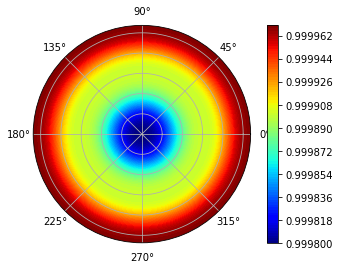

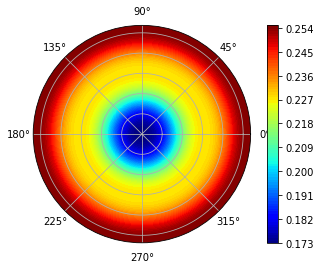

In [23]:
import matplotlib.cm as cm

plt.figure(1)

A, B = np.meshgrid(r1, ph)

#actual plotting
ax = plt.subplot(111, polar=True)
ax.set_yticklabels([])
ctf = ax.contourf(ph, r1, 2.*OmqSol[0,:,:],100, cmap=cm.jet)
plt.colorbar(ctf)

plt.figure(2)

A, B = np.meshgrid(r1, ph)

#actual plotting
ax = plt.subplot(111, polar=True)
ax.set_yticklabels([])
ctf = ax.contourf(ph, r1, 2.*(Hini/H0)**2.*OmqSol[-1,:,:],100, cmap=cm.jet)
plt.colorbar(ctf)

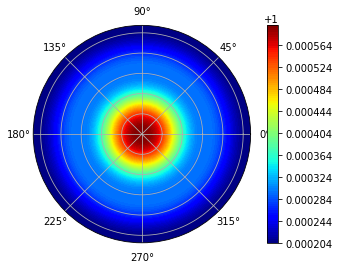

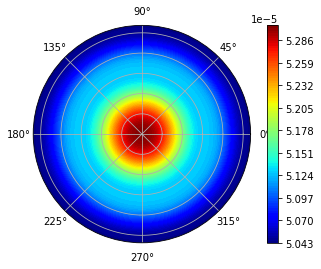

In [24]:
import matplotlib.cm as cm

plt.figure(1)

A, B = np.meshgrid(r1, ph)

#actual plotting
ax = plt.subplot(111, polar=True)
ax.set_yticklabels([])
ctf = ax.contourf(ph, r1, HqSol[0,:,:],100, cmap=cm.jet)
plt.colorbar(ctf)

plt.figure(2)

A, B = np.meshgrid(r1, ph)

#actual plotting
ax = plt.subplot(111, polar=True)
ax.set_yticklabels([])
ctf = ax.contourf(ph, r1, HqSol[-1,:,:],100, cmap=cm.jet)
plt.colorbar(ctf)

[]

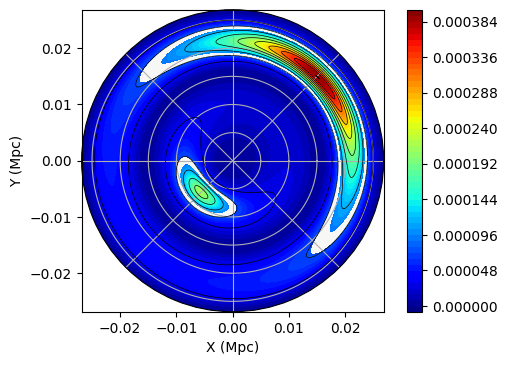

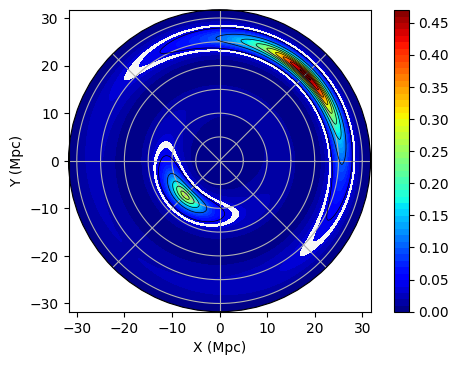

In [25]:
from matplotlib import ticker, cm

fig1 = plt.figure(1,dpi=100)

A, B = np.meshgrid(r1, ph)

#actual plotting
ax = plt.subplot(111, polar=True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ctfm = ax.contourf(ph, r1*aSol[0,:,0], 2.*DmSol[0,:,:],50, cmap='jet')#,locator=ticker.LogLocator(), cmap=cm.jet)
ctfm4 = ax.contourf(ph, r1*aSol[0,:,0], 2.*DmSol[0,:,:],levels=np.linspace(0.000075, 0.00009, 2), cmap='PiYG')#,locator=ticker.LogLocator(), cmap=cm.jet)


CS2 = ax.contour(ctfm, levels=ctfm.levels[::5], colors='black',linewidths=0.5)
plt.colorbar(ctfm)

new_axis = fig1.add_axes(ax.get_position(), frameon = True, xlabel = 'X (Mpc)', ylabel = 'Y (Mpc)',xlim = (-r1[-1]*aSol[0,-1,0],r1[-1]*aSol[0,-1,0]),ylim = (-r1[-1]*aSol[0,-1,0],r1[-1]*aSol[0,-1,0]))
new_axis.patch.set_alpha(0)
new_axis.plot()

#plt.savefig('/Users/klesto92/Documents/TesisDoctorado/Tensor Bel-Robinson/GraficasSzekeresI/DrhoIni.png',bbox_inches='tight',dpi=300)

fig2 = plt.figure(2,dpi=100)

A, B = np.meshgrid(r1*l*aSol[-1,:,0], ph)

#actual plotting
ax = plt.subplot(111, polar=True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ctfm2 = ax.contourf(ph, r1*aSol[-1,:,0], 2.*(Hini/H0)**2.*DmSol[-1,:,:],50, cmap='jet')#,locator=ticker.LogLocator(), cmap=cm.jet)
ctfm3 = ax.contourf(ph, r1*aSol[-1,:,0], 2.*(Hini/H0)**2.*DmSol[-1,:,:],levels=np.linspace(0.035, 0.04, 2), cmap='PiYG')#,locator=ticker.LogLocator(), cmap=cm.jet)

CS2 = ax.contour(ctfm2, levels=ctfm2.levels[::5], colors='black',linewidths=0.5)
plt.colorbar(ctfm2)

new_axis = fig2.add_axes(ax.get_position(), frameon = True, xlabel = 'X (Mpc)', ylabel = 'Y (Mpc)',xlim = (-r1[-1]*aSol[-1,-1,0],r1[-1]*aSol[-1,-1,0]),ylim = (-r1[-1]*aSol[-1,-1,0],r1[-1]*aSol[-1,-1,0]))
new_axis.patch.set_alpha(0)
new_axis.plot()



#plt.savefig('/Users/klesto92/Documents/TesisDoctorado/Tensor Bel-Robinson/GraficasSzekeresI/DrhoF.png',bbox_inches='tight',dpi=300)

[]

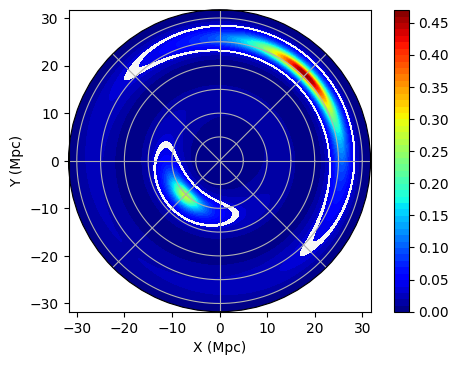

In [26]:
fig2 = plt.figure(2,dpi=100)

A, B = np.meshgrid(r1*l*aSol[-1,:,0], ph)

#actual plotting
ax = plt.subplot(111, polar=True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ctfm2 = ax.contourf(ph, r1*aSol[-1,:,0], 2.*(Hini/H0)**2.*DmSol[-1,:,:],50, cmap='jet')
ctfm3 = ax.contourf(ph, r1*aSol[-1,:,0], 2.*(Hini/H0)**2.*DmSol[-1,:,:],levels=np.linspace(0.035, 0.04, 2), cmap='PiYG')#,locator=ticker.LogLocator(), cmap=cm.jet)

plt.colorbar(ctfm2)

new_axis = fig2.add_axes(ax.get_position(), frameon = True, xlabel = 'X (Mpc)', ylabel = 'Y (Mpc)',xlim = (-r1[-1]*aSol[-1,-1,0],r1[-1]*aSol[-1,-1,0]),ylim = (-r1[-1]*aSol[-1,-1,0],r1[-1]*aSol[-1,-1,0]))
new_axis.patch.set_alpha(0)
new_axis.plot()

[]

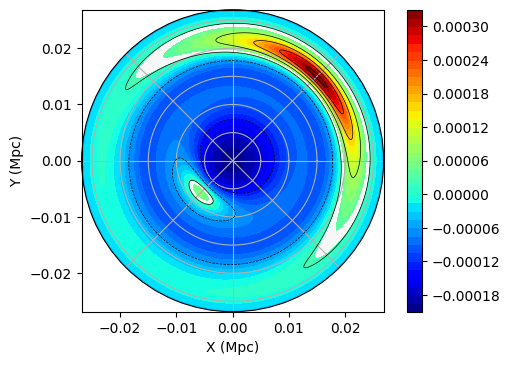

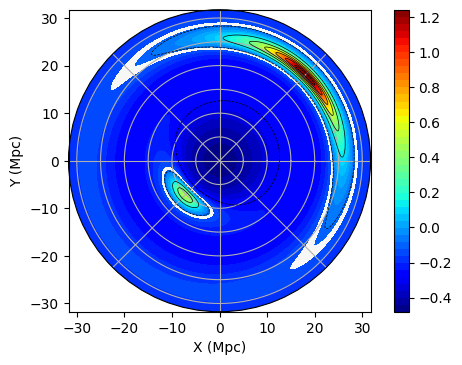

In [27]:
from matplotlib import ticker, cm

fig1 = plt.figure(1,dpi=100)

A, B = np.meshgrid(r1, ph)

#actual plotting
ax = plt.subplot(111, polar=True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ctf = ax.contourf(ph, r1*aSol[0,:,0], 2*OmSol[0,:,:]-1,50, cmap='jet')#,locator=ticker.LogLocator(), cmap=cm.jet)
ctf2 = ax.contourf(ph, r1*aSol[0,:,0], 2*OmSol[0,:,:]-1,levels=np.linspace(0.00002, 0.000035, 2), cmap='PiYG')#,locator=ticker.LogLocator(), cmap=cm.jet)

CS2 = ax.contour(ctf, levels=ctf.levels[::5], colors='black',linewidths=0.5)
plt.colorbar(ctf)

new_axis = fig1.add_axes(ax.get_position(), frameon = True, xlabel = 'X (Mpc)', ylabel = 'Y (Mpc)',xlim = (-r1[-1]*aSol[0,-1,0],r1[-1]*aSol[0,-1,0]),ylim = (-r1[-1]*aSol[0,-1,0],r1[-1]*aSol[0,-1,0]))
new_axis.patch.set_alpha(0)
new_axis.plot()

#plt.savefig('/Users/klesto92/Documents/TesisDoctorado/Tensor Bel-Robinson/GraficasSzekeresI/DeltarhoIni.png',bbox_inches='tight',dpi=300)

fig2 = plt.figure(2,dpi=100)

A, B = np.meshgrid(r1*l*aSol[-1,:,0], ph)

#actual plotting
ax = plt.subplot(111, polar=True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ctf = ax.contourf(ph, r1*aSol[-1,:,0], (2.*(Hini/H0)**2.*OmSol[-1,:,:]/OmCDM)-1,50, cmap='jet')#,locator=ticker.LogLocator(), cmap=cm.jet)
ctf2 = ax.contourf(ph, r1*aSol[-1,:,0],  (2.*(Hini/H0)**2.*OmSol[-1,:,:]/OmCDM)-1,levels=np.linspace(-0.12, -0.1, 2), cmap='PiYG')

CS2 = ax.contour(ctf, levels=ctf.levels[::5], colors='black',linewidths=0.5)
plt.colorbar(ctf)

new_axis = fig2.add_axes(ax.get_position(), frameon = True, xlabel = 'X (Mpc)', ylabel = 'Y (Mpc)',xlim = (-r1[-1]*aSol[-1,-1,0],r1[-1]*aSol[-1,-1,0]),ylim = (-r1[-1]*aSol[-1,-1,0],r1[-1]*aSol[-1,-1,0]))
new_axis.patch.set_alpha(0)
new_axis.plot()



#plt.savefig('/Users/klesto92/Documents/TesisDoctorado/Tensor Bel-Robinson/GraficasSzekeresI/Deltarhof.png',bbox_inches='tight',dpi=300)

[]

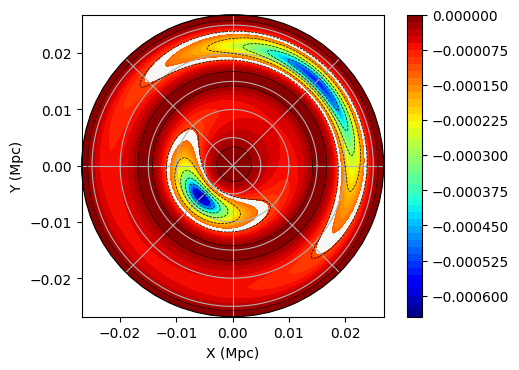

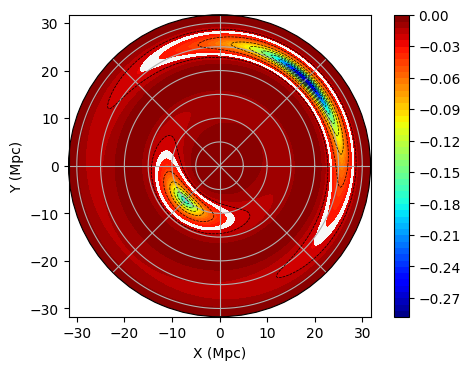

In [28]:
fig1 = plt.figure(1,dpi=100)

A, B = np.meshgrid(r1, ph)

#actual plotting
ax = plt.subplot(111, polar=True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ctfh = ax.contourf(ph, r1*aSol[0,:,0], DhSol[0,:,:],50, cmap='jet')#,locator=ticker.LogLocator(), cmap=cm.jet)
ctfh3 = ax.contourf(ph, r1*aSol[0,:,0], DhSol[0,:,:],levels=np.linspace(-0.00013, -0.00011, 2), cmap='PiYG')

CS2 = ax.contour(ctfh, levels=ctfh.levels[::6], colors='black',linewidths=0.5)
plt.colorbar(ctfh)

new_axis = fig1.add_axes(ax.get_position(), frameon = True, xlabel = 'X (Mpc)', ylabel = 'Y (Mpc)',xlim = (-r1[-1]*aSol[0,-1,0],r1[-1]*aSol[0,-1,0]),ylim = (-r1[-1]*aSol[0,-1,0],r1[-1]*aSol[0,-1,0]))
new_axis.patch.set_alpha(0)
new_axis.plot()

#plt.savefig('/Users/klesto92/Documents/TesisDoctorado/Tensor Bel-Robinson/GraficasSzekeresI/DhIni.png',bbox_inches='tight',dpi=300)

fig2 = plt.figure(2,dpi=100)

A, B = np.meshgrid(r1*l*aSol[-1,:,0], ph)

#actual plotting
ax = plt.subplot(111, polar=True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ctfh2 = ax.contourf(ph, r1*aSol[-1,:,0], (Hini/H0)*DhSol[-1,:,:],50, cmap='jet')#,locator=ticker.LogLocator(), cmap=cm.jet)
ctfh4 = ax.contourf(ph, r1*aSol[-1,:,0], (Hini/H0)*DhSol[-1,:,:],levels=np.linspace(-0.03, -0.025, 2), cmap='PiYG')

CS2 = ax.contour(ctfh2, levels=ctfh2.levels[::5], colors='black',linewidths=0.5)
plt.colorbar(ctfh2)

new_axis = fig2.add_axes(ax.get_position(), frameon = True, xlabel = 'X (Mpc)', ylabel = 'Y (Mpc)',xlim = (-r1[-1]*aSol[-1,-1,0],r1[-1]*aSol[-1,-1,0]),ylim = (-r1[-1]*aSol[-1,-1,0],r1[-1]*aSol[-1,-1,0]))
new_axis.patch.set_alpha(0)
new_axis.plot()



#plt.savefig('/Users/klesto92/Documents/TesisDoctorado/Tensor Bel-Robinson/GraficasSzekeresI/Dhf.png',bbox_inches='tight',dpi=300)


[]

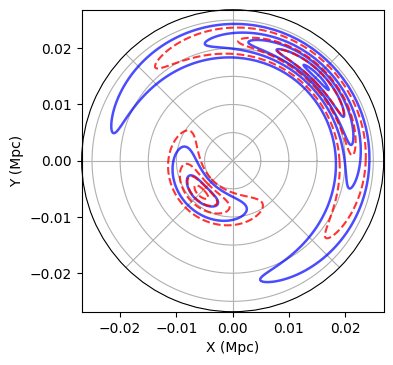

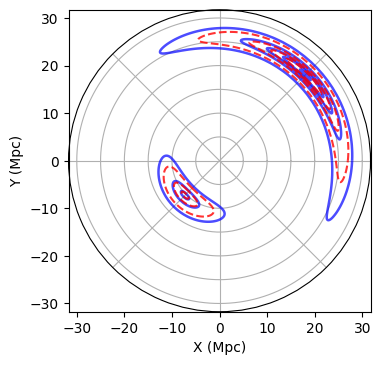

In [29]:
from matplotlib import ticker, cm

fig1 = plt.figure(1,dpi=100)

A, B = np.meshgrid(r1, ph)

#actual plotting
ax = plt.subplot(111, polar=True)
ax.set_xticklabels([])
ax.set_yticklabels([])
CS3= ax.contour(ctfm, levels=ctfm.levels[8::10], colors='blue',linewidths=1.8,alpha=0.7)
CS4 = ax.contour(ctfh, levels=ctfh.levels[5::10], colors='red',linewidths=1.5,alpha=0.8)

new_axis = fig1.add_axes(ax.get_position(), frameon = True, xlabel = 'X (Mpc)', ylabel = 'Y (Mpc)',xlim = (-r1[-1]*aSol[0,-1,0],r1[-1]*aSol[0,-1,0]),ylim = (-r1[-1]*aSol[0,-1,0],r1[-1]*aSol[0,-1,0]))
new_axis.patch.set_alpha(0)
new_axis.plot()

#plt.savefig('/Users/klesto92/Documents/TesisDoctorado/Tensor Bel-Robinson/GraficasSzekeresI/DrhoDhIni.png',bbox_inches='tight',dpi=300)

fig2 = plt.figure(2,dpi=100)

A, B = np.meshgrid(r1*l*aSol[-1,:,0], ph)

#actual plotting
ax = plt.subplot(111, polar=True)
ax.set_xticklabels([])
ax.set_yticklabels([])
CS5 = ax.contour(ctfm2, levels=ctfm2.levels[5::10], colors='blue',linewidths=1.8, linestyles='solid',alpha=0.7)
CS6 = ax.contour(ctfh2, levels=ctfh2.levels[::10], colors='red',linewidths=1.5, linestyles='dashed',alpha=0.8)

new_axis = fig2.add_axes(ax.get_position(), frameon = True, xlabel = 'X (Mpc)', ylabel = 'Y (Mpc)',xlim = (-r1[-1]*aSol[-1,-1,0],r1[-1]*aSol[-1,-1,0]),ylim = (-r1[-1]*aSol[-1,-1,0],r1[-1]*aSol[-1,-1,0]))
new_axis.patch.set_alpha(0)
new_axis.plot()



#plt.savefig('/Users/klesto92/Documents/TesisDoctorado/Tensor Bel-Robinson/GraficasSzekeresI/DrhoDhf.png',bbox_inches='tight',dpi=300)

[]

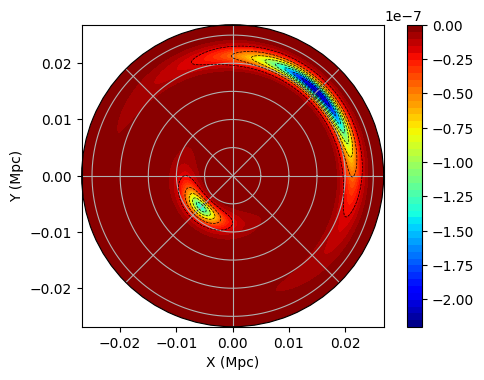

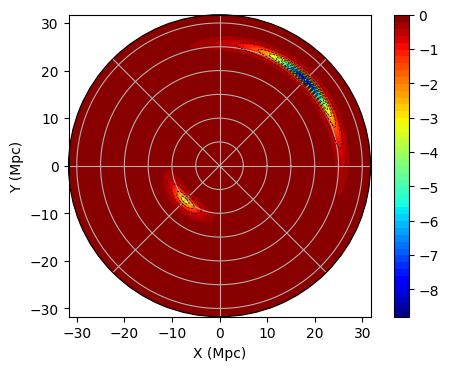

In [30]:
fig1 = plt.figure(1,dpi=100)

A, B = np.meshgrid(r1, ph)

#actual plotting
ax = plt.subplot(111, polar=True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ctf = ax.contourf(ph, r1*aSol[0,:,0], 2.*DmSol[0,:,:]*DhSol[0,:,:],50, cmap='jet')#,locator=ticker.LogLocator(), cmap=cm.jet)
CS2 = ax.contour(ctf, levels=ctf.levels[::5], colors='black',linewidths=0.5)
plt.colorbar(ctf)

new_axis = fig1.add_axes(ax.get_position(), frameon = True, xlabel = 'X (Mpc)', ylabel = 'Y (Mpc)',xlim = (-r1[-1]*aSol[0,-1,0],r1[-1]*aSol[0,-1,0]),ylim = (-r1[-1]*aSol[0,-1,0],r1[-1]*aSol[0,-1,0]))
new_axis.patch.set_alpha(0)
new_axis.plot()

#plt.savefig('/Users/klesto92/Documents/TesisDoctorado/Tensor Bel-Robinson/GraficasSzekeresI/DrhoDhIni2.png',bbox_inches='tight',dpi=300)

fig2 = plt.figure(2,dpi=100)

A, B = np.meshgrid(r1*l*aSol[-1,:,0], ph)

#actual plotting
ax = plt.subplot(111, polar=True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ctf = ax.contourf(ph, r1*aSol[-1,:,0], 2.*(Hini/H0)**2.*DmSol[-1,:,:]*Hini*DhSol[-1,:,:],50, cmap='jet')#,locator=ticker.LogLocator(), cmap=cm.jet)
CS2 = ax.contour(ctf, levels=ctf.levels[::5], colors='black',linewidths=0.5)
plt.colorbar(ctf)

new_axis = fig2.add_axes(ax.get_position(), frameon = True, xlabel = 'X (Mpc)', ylabel = 'Y (Mpc)',xlim = (-r1[-1]*aSol[-1,-1,0],r1[-1]*aSol[-1,-1,0]),ylim = (-r1[-1]*aSol[-1,-1,0],r1[-1]*aSol[-1,-1,0]))
new_axis.patch.set_alpha(0)
new_axis.plot()



#plt.savefig('/Users/klesto92/Documents/TesisDoctorado/Tensor Bel-Robinson/GraficasSzekeresI/DrhoDhf2.png',bbox_inches='tight',dpi=300)

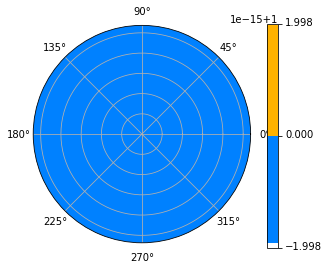

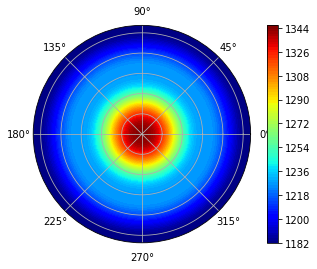

In [31]:
import matplotlib.cm as cm

plt.figure(1)

A, B = np.meshgrid(r1, ph)

#actual plotting
ax = plt.subplot(111, polar=True)
ax.set_yticklabels([])
ctf = ax.contourf(ph, r1, aSol[0,:,:],100, cmap=cm.jet)
plt.colorbar(ctf)

plt.figure(2)

A, B = np.meshgrid(r1, ph)

#actual plotting
ax = plt.subplot(111, polar=True)
ax.set_yticklabels([])
ctf = ax.contourf(ph, r1, aSol[-1,:,:],100, cmap=cm.jet)
plt.colorbar(ctf)

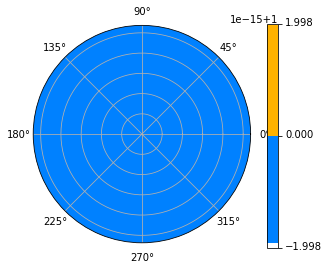

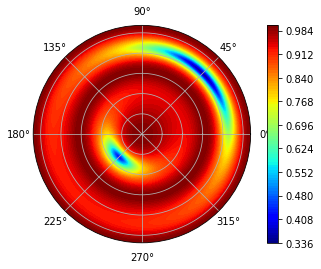

In [32]:
import matplotlib.cm as cm

plt.figure(1)

A, B = np.meshgrid(r1, ph)

#actual plotting
ax = plt.subplot(111, polar=True)
ax.set_yticklabels([])
ctf = ax.contourf(ph, r1, GSol[0,:,:],100, cmap=cm.jet)
plt.colorbar(ctf)

plt.figure(2)

A, B = np.meshgrid(r1, ph)

#actual plotting
ax = plt.subplot(111, polar=True)
ax.set_yticklabels([])
ctf = ax.contourf(ph, r1, GSol[-1,:,:],100, cmap=cm.jet)
plt.colorbar(ctf)

[]

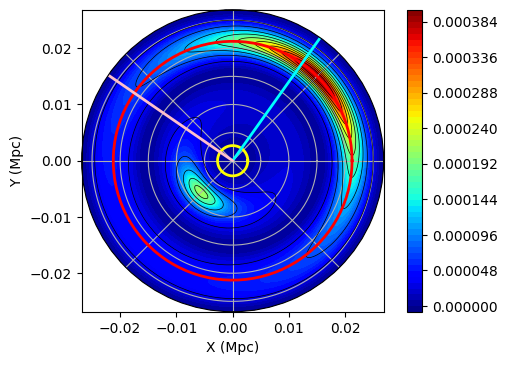

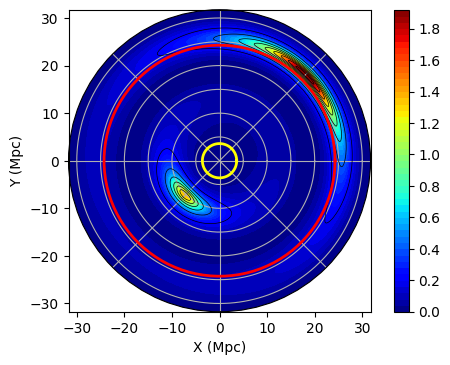

In [56]:
from matplotlib import ticker, cm

fig1 = plt.figure(1,dpi=100)

A, B = np.meshgrid(r1, ph)

#actual plotting
ax = plt.subplot(111, polar=True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ctfm = ax.contourf(ph, r1*aSol[0,:,0], DelqMSol[0,:,:],50, cmap='jet')#,locator=ticker.LogLocator(), cmap=cm.jet)
circsd1 = ax.plot(ph[:], r1[790]*aSol[0,790,:],color='red',linewidth=2.0) #, cmap='PiYG')#,locator=ticker.LogLocator(), cmap=cm.jet)
circv1 = ax.plot(ph[:], r1[100]*aSol[0,100,:],color='yellow',linewidth=2.0)
rad1 = ax.plot([ph[15],ph[15]], [r1[0]*aSol[0,0,15],r1[-1]*aSol[0,-1,15]],color='cyan',linewidth=2.0)
rad2 = ax.plot([ph[40],ph[40]], [r1[0]*aSol[0,0,40],r1[-1]*aSol[0,-1,40]],color='pink',linewidth=2.0)

CS2 = ax.contour(ctfm, levels=ctfm.levels[::5], colors='black',linewidths=0.5)
plt.colorbar(ctfm)

new_axis = fig1.add_axes(ax.get_position(), frameon = True, xlabel = 'X (Mpc)', ylabel = 'Y (Mpc)',xlim = (-r1[-1]*aSol[0,-1,0],r1[-1]*aSol[0,-1,0]),ylim = (-r1[-1]*aSol[0,-1,0],r1[-1]*aSol[0,-1,0]))
new_axis.patch.set_alpha(0)
new_axis.plot()

#plt.savefig('/Users/klesto92/Documents/TesisDoctorado/Tensor Bel-Robinson/GraficasSzekeresI/DeltrhoqIni.png',bbox_inches='tight',dpi=300)

fig2 = plt.figure(2,dpi=100)

A, B = np.meshgrid(r1*l*aSol[-1,:,0], ph)

#actual plotting
ax = plt.subplot(111, polar=True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ctfm2 = ax.contourf(ph, r1*aSol[-1,:,0], DelqMSol[-1,:,:],50, cmap='jet')#,locator=ticker.LogLocator(), cmap=cm.jet)
ciecsd2 = ax.plot(ph[:], r1[750]*aSol[-1,790,:],color='red',linewidth=2.0) #, cmap='PiYG')#,locator=ticker.LogLocator(), cmap=cm.jet)
circv2 = ax.plot(ph[:], r1[100]*aSol[-1,100,:],color='yellow',linewidth=2.0)
#rad3 = ax.plot([ph[15],ph[15]], [r1[0]*aSol[-1,0,15],r1[-1]*aSol[-1,-1,15]],color='cyan',linewidth=2.0)
#rad4 = ax.plot([ph[40],ph[40]], [r1[0]*aSol[-1,0,40],r1[-1]*aSol[-1,-1,40]],color='pink',linewidth=2.0)

CS2 = ax.contour(ctfm2, levels=ctfm2.levels[::5], colors='black',linewidths=0.5)
plt.colorbar(ctfm2)

new_axis = fig2.add_axes(ax.get_position(), frameon = True, xlabel = 'X (Mpc)', ylabel = 'Y (Mpc)',xlim = (-r1[-1]*aSol[-1,-1,0],r1[-1]*aSol[-1,-1,0]),ylim = (-r1[-1]*aSol[-1,-1,0],r1[-1]*aSol[-1,-1,0]))
new_axis.patch.set_alpha(0)
new_axis.plot()



#plt.savefig('/Users/klesto92/Documents/TesisDoctorado/Tensor Bel-Robinson/GraficasSzekeresI/DeltrhoqF.png',bbox_inches='tight',dpi=300)

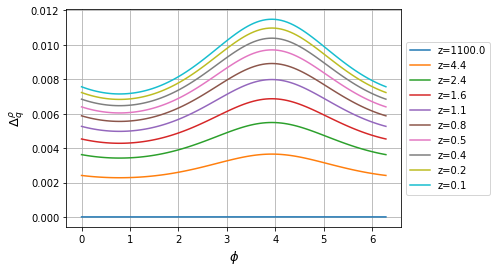

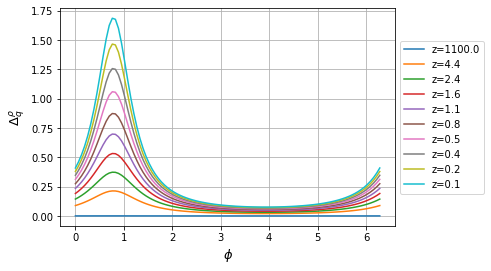

In [81]:
plt.figure(1)

for i in range(0, len(times), 100):
    plt.plot(ph, DelqMSol[i,100,:], label='z={0:1.1f}'.format(z1[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes = plt.gca()
#axes.set_xlim([-1,70])
plt.xlabel('$\phi$',size='13')
plt.ylabel(r'$\Delta^\rho_q$',size='13')

axes = plt.gca()


plt.grid(True)

#plt.savefig('/Users/klesto92/Documents/TesisDoctorado/Tensor Bel-Robinson/GraficasSzekeresI/DeltroqphiV.png',bbox_inches='tight',dpi=300)

plt.figure(2)

#se realiza una grafica de la soluciones rho vs r para cada paso de tiempo de integracion

for i in range(0, len(times), 100):
    plt.plot(ph, DelqMSol[i,790,:], label='z={0:1.1f}'.format(z1[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes = plt.gca()
#axes.set_xlim([-1,70])
plt.xlabel('$\phi$',size='13')
plt.ylabel(r'$\Delta^\rho_q$',size='13')

axes = plt.gca()


plt.grid(True)


#plt.savefig('/Users/klesto92/Documents/TesisDoctorado/Tensor Bel-Robinson/GraficasSzekeresI/DeltrhoqphiSD.png',bbox_inches='tight',dpi=300)

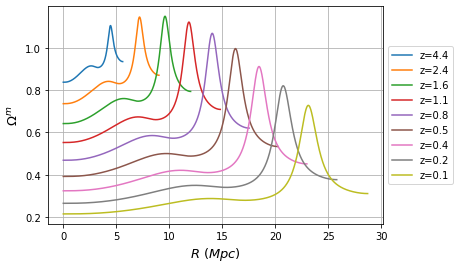

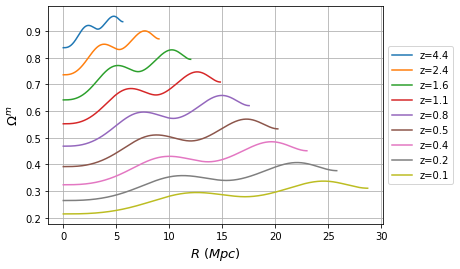

In [75]:
plt.figure(1)

for i in range(100, len(times), 100):
    plt.plot(r1*aSol[i,:,15], 2.*(Hini/Hz[i])**2.*OmSol[i,:,15], label='z={0:1.1f}'.format(z1[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes = plt.gca()
#axes.set_xlim([-1,70])
plt.xlabel('$R\ (Mpc)$',size='13')
plt.ylabel(r'$\Omega^m$',size='13')

axes = plt.gca()


plt.grid(True)

#plt.savefig('/Users/klesto92/Documents/TesisDoctorado/Tensor Bel-Robinson/GraficasSzekeresI/rhoqiRSD.png',bbox_inches='tight',dpi=300)

plt.figure(2)

#se realiza una grafica de la soluciones rho vs r para cada paso de tiempo de integracion

for i in range(100, len(times), 100):
    plt.plot(r1*aSol[i,:,40], 2.*(Hini/Hz[i])**2.*OmSol[i,:,40], label='z={0:1.1f}'.format(z1[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes = plt.gca()
#axes.set_xlim([-1,70])
plt.xlabel('$R\ (Mpc)$',size='13')
plt.ylabel(r'$\Omega^m$',size='13')

axes = plt.gca()


plt.grid(True)


#plt.savefig('/Users/klesto92/Documents/TesisDoctorado/Tensor Bel-Robinson/GraficasSzekeresI/rhoqiRV.png',bbox_inches='tight',dpi=300)

In [85]:
rhoz1max = np.amax(OmSol[i,:,15])
coordmax = np.where(OmSol[i,:,15] == rhoz1max)

coordmax

r1[790]

0.02122798798798799

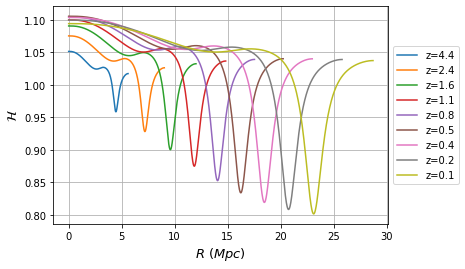

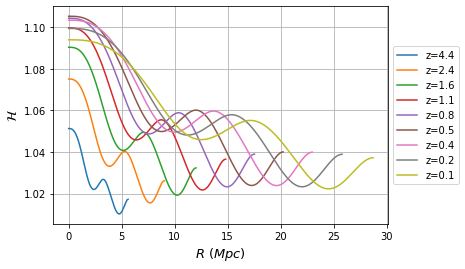

In [74]:
plt.figure(1)

for i in range(100, len(times), 100):
    plt.plot(r1*aSol[i,:,15], (Hini/Hz[i])*HSol[i,:,15], label='z={0:1.1f}'.format(z1[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes = plt.gca()
#axes.set_xlim([-1,70])
plt.xlabel('$R\ (Mpc)$',size='13')
plt.ylabel(r'$\mathcal{H}$',size='13')

axes = plt.gca()


plt.grid(True)

#plt.savefig('/Users/klesto92/Documents/TesisDoctorado/Tensor Bel-Robinson/GraficasSzekeresI/hiRSD.png',bbox_inches='tight',dpi=300)

plt.figure(2)

#se realiza una grafica de la soluciones rho vs r para cada paso de tiempo de integracion

for i in range(100, len(times), 100):
    plt.plot(r1*aSol[i,:,40], (Hini/Hz[i])*HSol[i,:,40], label='z={0:1.1f}'.format(z1[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes = plt.gca()
#axes.set_xlim([-1,70])
plt.xlabel('$R\ (Mpc)$',size='13')
plt.ylabel(r'$\mathcal{H}$',size='13')

axes = plt.gca()


plt.grid(True)


#plt.savefig('/Users/klesto92/Documents/TesisDoctorado/Tensor Bel-Robinson/GraficasSzekeresI/hiRV.png',bbox_inches='tight',dpi=300)

In [37]:
KqSol = 2*OmqSol+OmLin - HqSol**2.

DkSol = 2*(DmSol-HqSol*DhSol)

KSol = DkSol+KqSol


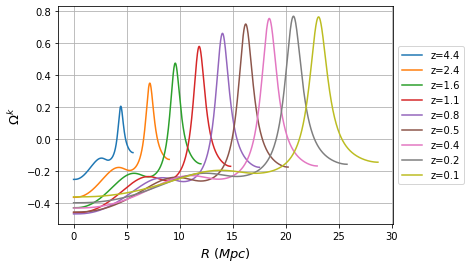

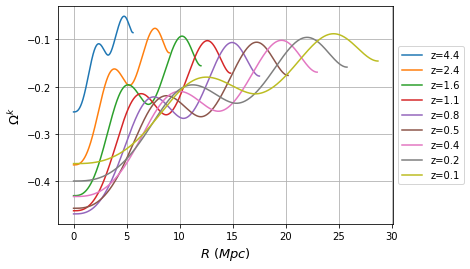

In [82]:
plt.figure(1)

for i in range(100, len(times), 100):
    plt.plot(r1*aSol[i,:,15], (Hini/Hz[i])**2.*KSol[i,:,15], label='z={0:1.1f}'.format(z1[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes = plt.gca()
#axes.set_xlim([-1,70])
plt.xlabel('$R\ (Mpc)$',size='13')
plt.ylabel(r'$\Omega^{k}$',size='13')

axes = plt.gca()


plt.grid(True)

#plt.savefig('/Users/klesto92/Documents/TesisDoctorado/Tensor Bel-Robinson/GraficasSzekeresI/kiRSD.png',bbox_inches='tight',dpi=300)

plt.figure(2)

#se realiza una grafica de la soluciones rho vs r para cada paso de tiempo de integracion

for i in range(100, len(times), 100):
    plt.plot(r1*aSol[i,:,40], (Hini/Hz[i])**2.*KSol[i,:,40], label='z={0:1.1f}'.format(z1[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes = plt.gca()
#axes.set_xlim([-1,70])
plt.xlabel('$R\ (Mpc)$',size='13')
plt.ylabel(r'$\Omega^{k}$',size='13')

axes = plt.gca()


plt.grid(True)


#plt.savefig('/Users/klesto92/Documents/TesisDoctorado/Tensor Bel-Robinson/GraficasSzekeresI/kiRV.png',bbox_inches='tight',dpi=300)

In [39]:
#z1

# LTB seed model

In [40]:
dmLTB = DmSol*(GamWSol/GamSol)

OmLTB = dmLTB+OmqSol



In [41]:
dhLTB = DhSol*(GamWSol/GamSol)

HLTB = dhLTB+HqSol


In [42]:
dkLTB = DkSol*(GamWSol/GamSol)

KLTB = dkLTB + KqSol



In [43]:
deltLTB = dmLTB[0,:,0]/OmqSol[0,:,0]
deltkLTB = dkLTB[0,:,0]/KqSol[0,:,0]



[]

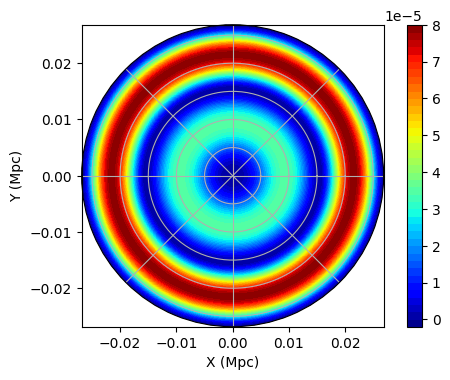

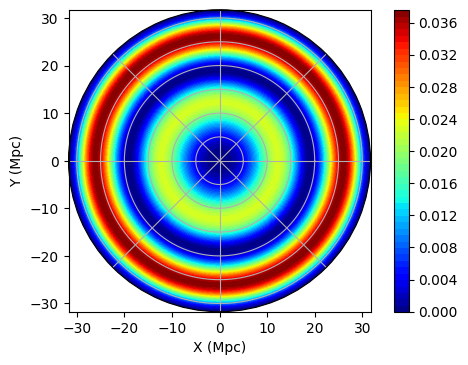

In [44]:
from matplotlib import ticker, cm

fig1 = plt.figure(1,dpi=100)

A, B = np.meshgrid(r1, ph)

#actual plotting
ax = plt.subplot(111, polar=True)
ax.set_xticklabels([])
ax.set_yticklabels([])
LTBdi = ax.contourf(ph, r1*aSol[0,:,0], 2.*dmLTB[0,:,:],50, cmap='jet')#,locator=ticker.LogLocator(), cmap=cm.jet)
#ctfm4 = ax.contourf(ph, r1*aSol[0,:,0], 2.*DmSol[0,:,:]*(GamWSol[0,:,:]/GamSol[0,:,:]),levels=np.linspace(0.000075, 0.00009, 2), cmap='PiYG')#,locator=ticker.LogLocator(), cmap=cm.jet)


#CS2 = ax.contour(LTBdi, levels=ctfm.levels[::5], colors='black',linewidths=0.5)
plt.colorbar(LTBdi)

new_axis = fig1.add_axes(ax.get_position(), frameon = True, xlabel = 'X (Mpc)', ylabel = 'Y (Mpc)',xlim = (-r1[-1]*aSol[0,-1,0],r1[-1]*aSol[0,-1,0]),ylim = (-r1[-1]*aSol[0,-1,0],r1[-1]*aSol[0,-1,0]))
new_axis.patch.set_alpha(0)
new_axis.plot()

#plt.savefig('/Users/klesto92/Documents/TesisDoctorado/Tensor Bel-Robinson/GraficasSzekeresI/DrhoIni.png',bbox_inches='tight',dpi=300)

fig2 = plt.figure(2,dpi=100)

A, B = np.meshgrid(r1*l*aSol[-1,:,0], ph)

#actual plotting
ax = plt.subplot(111, polar=True)
ax.set_xticklabels([])
ax.set_yticklabels([])
LTBdf = ax.contourf(ph, r1*aSol[-1,:,0], 2.*(Hini/H0)**2.*dmLTB[-1,:,:],50, cmap='jet')#,locator=ticker.LogLocator(), cmap=cm.jet)
#ctfm3 = ax.contourf(ph, r1*aSol[-1,:,0], 2.*(Hini/H0)**2.*DmSol[-1,:,:]*(GamWSol[-1,:,:]/GamSol[-1,:,:]),levels=np.linspace(0.035, 0.04, 2), cmap='PiYG')#,locator=ticker.LogLocator(), cmap=cm.jet)

#CS2 = ax.contour(LTBdf, levels=ctfm2.levels[::5], colors='black',linewidths=0.5)
plt.colorbar(LTBdf)

new_axis = fig2.add_axes(ax.get_position(), frameon = True, xlabel = 'X (Mpc)', ylabel = 'Y (Mpc)',xlim = (-r1[-1]*aSol[-1,-1,0],r1[-1]*aSol[-1,-1,0]),ylim = (-r1[-1]*aSol[-1,-1,0],r1[-1]*aSol[-1,-1,0]))
new_axis.patch.set_alpha(0)
new_axis.plot()



#plt.savefig('/Users/klesto92/Documents/TesisDoctorado/Tensor Bel-Robinson/GraficasSzekeresI/DrhoF.png',bbox_inches='tight',dpi=300)

[]

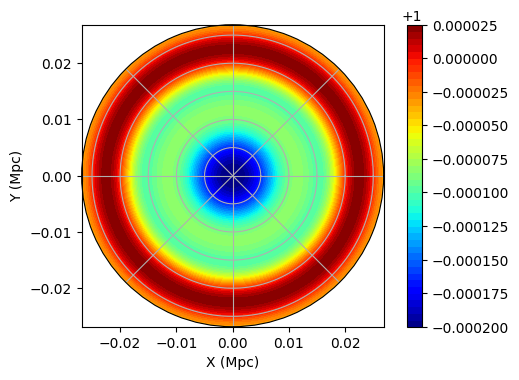

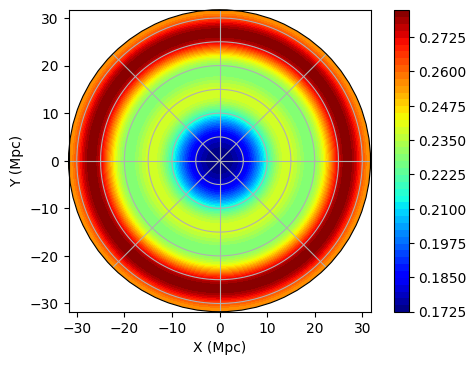

In [45]:
from matplotlib import ticker, cm

fig1 = plt.figure(1,dpi=100)

A, B = np.meshgrid(r1, ph)

#actual plotting
ax = plt.subplot(111, polar=True)
ax.set_xticklabels([])
ax.set_yticklabels([])
LTBdi = ax.contourf(ph, r1*aSol[0,:,0], 2.*OmLTB[0,:,:],50, cmap='jet')#,locator=ticker.LogLocator(), cmap=cm.jet)
#ctfm4 = ax.contourf(ph, r1*aSol[0,:,0], 2.*DmSol[0,:,:]*(GamWSol[0,:,:]/GamSol[0,:,:]),levels=np.linspace(0.000075, 0.00009, 2), cmap='PiYG')#,locator=ticker.LogLocator(), cmap=cm.jet)


#CS2 = ax.contour(LTBdi, levels=ctfm.levels[::5], colors='black',linewidths=0.5)
plt.colorbar(LTBdi)

new_axis = fig1.add_axes(ax.get_position(), frameon = True, xlabel = 'X (Mpc)', ylabel = 'Y (Mpc)',xlim = (-r1[-1]*aSol[0,-1,0],r1[-1]*aSol[0,-1,0]),ylim = (-r1[-1]*aSol[0,-1,0],r1[-1]*aSol[0,-1,0]))
new_axis.patch.set_alpha(0)
new_axis.plot()

#plt.savefig('/Users/klesto92/Documents/TesisDoctorado/Tensor Bel-Robinson/GraficasSzekeresI/DrhoIni.png',bbox_inches='tight',dpi=300)

fig2 = plt.figure(2,dpi=100)

A, B = np.meshgrid(r1*l*aSol[-1,:,0], ph)

#actual plotting
ax = plt.subplot(111, polar=True)
ax.set_xticklabels([])
ax.set_yticklabels([])
LTBdf = ax.contourf(ph, r1*aSol[-1,:,0], 2.*(Hini/H0)**2.*OmLTB[-1,:,:],50, cmap='jet')#,locator=ticker.LogLocator(), cmap=cm.jet)
#ctfm3 = ax.contourf(ph, r1*aSol[-1,:,0], 2.*(Hini/H0)**2.*DmSol[-1,:,:]*(GamWSol[-1,:,:]/GamSol[-1,:,:]),levels=np.linspace(0.035, 0.04, 2), cmap='PiYG')#,locator=ticker.LogLocator(), cmap=cm.jet)

#CS2 = ax.contour(LTBdf, levels=ctfm2.levels[::5], colors='black',linewidths=0.5)
plt.colorbar(LTBdf)

new_axis = fig2.add_axes(ax.get_position(), frameon = True, xlabel = 'X (Mpc)', ylabel = 'Y (Mpc)',xlim = (-r1[-1]*aSol[-1,-1,0],r1[-1]*aSol[-1,-1,0]),ylim = (-r1[-1]*aSol[-1,-1,0],r1[-1]*aSol[-1,-1,0]))
new_axis.patch.set_alpha(0)
new_axis.plot()



#plt.savefig('/Users/klesto92/Documents/TesisDoctorado/Tensor Bel-Robinson/GraficasSzekeresI/DrhoF.png',bbox_inches='tight',dpi=300)

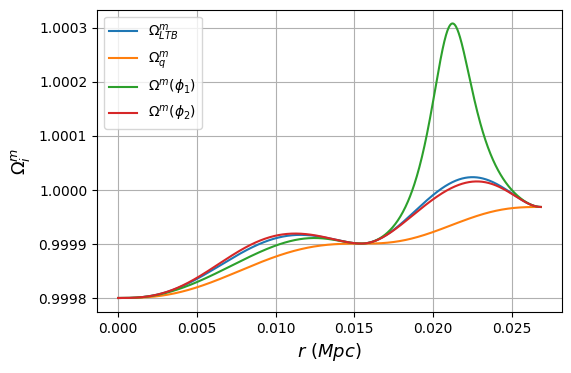

In [78]:
import matplotlib.ticker as mtick
fig1 = plt.figure(1,dpi=100)
plt.plot(r1,2*OmLTB[0,:,0],label=r'$\Omega^m_{LTB}$')
plt.plot(r1,2*OmqSol[0,:,0],label=r'$\Omega^m_q$')
plt.plot(r1,2*OmSol[0,:,15],label=r'$\Omega^m(\phi_1)$')
plt.plot(r1,2*OmSol[0,:,40],label=r'$\Omega^m(\phi_2)$')
plt.legend(loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.99975,1.00035])
axes.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.4f'))
plt.xlabel('$r\ (Mpc)$',size='13')
plt.ylabel(r'$\Omega^m_i$',size='13')
plt.grid(True)

#plt.savefig('/Users/klesto92/Documents/TesisDoctorado/Tensor Bel-Robinson/GraficasSzekeresI/rhoi.png',bbox_inches='tight',dpi=300)

#fig2 = plt.figure(2,dpi=100)
#plt.plot(r1,2.*(Hini/H0)**2.*OmLTB[-1,:,0],label=r'$\Omega^\rho$')
#plt.plot(r1,2.*(Hini/H0)**2.*OmqSol[-1,:,0],label=r'$\Omega_q$')
#plt.legend(loc='upper left')
#plt.xlabel('$r$',size='13')
#plt.ylabel(r'$\Omega^\rho$',size='13')



Text(0, 0.5, '$d^\\rho$')

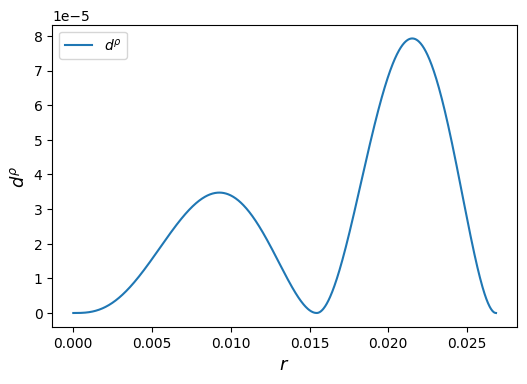

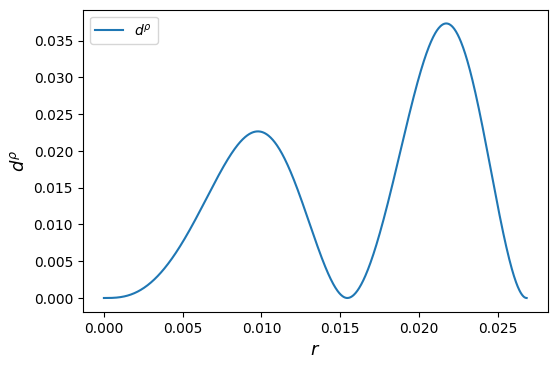

In [47]:
fig1 = plt.figure(1,dpi=100)
plt.plot(r1,2*dmLTB[0,:,0],label=r'$d^\rho$')
plt.legend(loc='upper left')
axes = plt.gca()
#axes.set_xlim([-1,70])
plt.xlabel('$r$',size='13')
plt.ylabel(r'$d^\rho$',size='13')

fig2 = plt.figure(2,dpi=100)
plt.plot(r1,2.*(Hini/H0)**2.*dmLTB[-1,:,0],label=r'$d^\rho$')
plt.legend(loc='upper left')
plt.xlabel('$r$',size='13')
plt.ylabel(r'$d^\rho$',size='13')

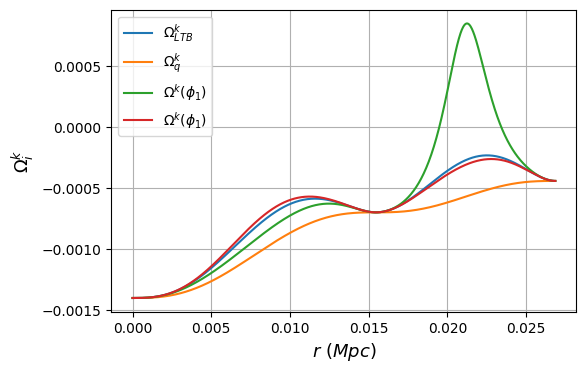

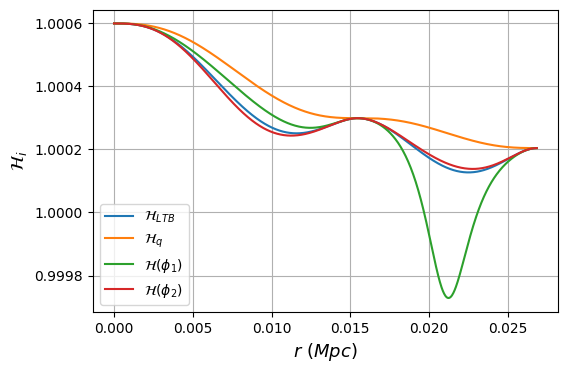

In [79]:
fig1 = plt.figure(1,dpi=100)
plt.plot(r1,KLTB[0,:,0],label=r'$\Omega^k_{LTB}$')
plt.plot(r1,KqSol[0,:,0],label=r'$\Omega^k_q$')
plt.plot(r1,KSol[0,:,15],label=r'$\Omega^k(\phi_1)$')
plt.plot(r1,KSol[0,:,40],label=r'$\Omega^k(\phi_1)$')
plt.legend(loc='upper left')
axes = plt.gca()
#axes.set_xlim([-1,70])
plt.xlabel('$r\ (Mpc)$',size='13')
plt.ylabel(r'$\Omega^k_i$',size='13')
plt.grid(True)

#plt.savefig('/Users/klesto92/Documents/TesisDoctorado/Tensor Bel-Robinson/GraficasSzekeresI/ki.png',bbox_inches='tight',dpi=300)



fig2 = plt.figure(2,dpi=100)
plt.plot(r1,HLTB[0,:,0],label=r'$\mathcal{H}_{LTB}$')
plt.plot(r1,HqSol[0,:,0],label=r'$\mathcal{H}_q$')
plt.plot(r1,HSol[0,:,15],label=r'$\mathcal{H}(\phi_1)$')
plt.plot(r1,HSol[0,:,40],label=r'$\mathcal{H}(\phi_2)$')
axes = plt.gca()
axes.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.4f'))
plt.legend(loc='lower left')
plt.xlabel('$r\ (Mpc)$',size='13')
plt.ylabel(r'$\mathcal{H}_i$',size='13')

plt.grid(True)

#plt.savefig('/Users/klesto92/Documents/TesisDoctorado/Tensor Bel-Robinson/GraficasSzekeresI/hi.png',bbox_inches='tight',dpi=300)



HLTB = dhLTB+HqSol



Text(0, 0.5, '$\\kappa$')

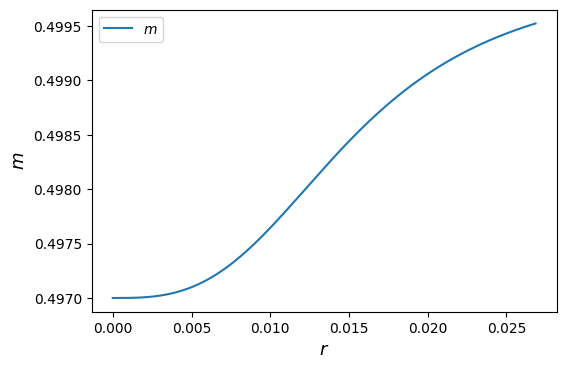

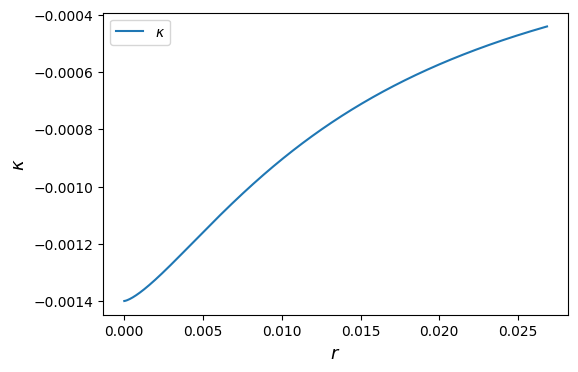

In [49]:
fig1 = plt.figure(1,dpi=100)
plt.plot(r1,M(r1),label=r'$m$')
plt.legend(loc='upper left')
axes = plt.gca()
#axes.set_xlim([-1,70])
plt.xlabel('$r$',size='13')
plt.ylabel(r'$m$',size='13')


fig2 = plt.figure(2,dpi=100)
plt.plot(r1,KK(r1),label=r'$\kappa$')
plt.legend(loc='upper left')
axes = plt.gca()
#axes.set_xlim([-1,70])
plt.xlabel('$r$',size='13')
plt.ylabel(r'$\kappa$',size='13')



In [50]:
#from scipy import integrate

In [51]:
#alphqi = np.abs(KqSol[0,:,0])/OmqSol[0,:,0]

#Hqtbb = np.sqrt(2.+alphqi)*(np.sqrt(alphqi)*np.sqrt(2+alphqi)-np.arccosh(1.+alphqi))/(alphqi)**(3./2.)

#tbbprim = 3.*(deltLTB-deltkLTB-(deltLTB-3.*deltkLTB/2.)*Hqtbb)/(HqSol[0,:,0]*r1)

#tbbprim[0] = 0

#tbb1 = integrate.cumtrapz(tbbprim,r1,initial=0)
#tbb = ti*10.**9. - Hqtbb/(HqSol[0,:,0]*Hinis*(60.*60.*24.*365.))


In [52]:
#fig1 = plt.figure(1,dpi=100)
#plt.plot(r1,tbbprim,label=r'$t^{\prime}_{bb}$')
#plt.legend(loc='lower left')
#axes = plt.gca()
#axes.set_xlim([-1,70])
#plt.xlabel('$r$',size='13')
#plt.ylabel(r'$t^{\prime}_{bb}$',size='13')
#plt.grid(True)


#fig2 = plt.figure(2,dpi=100)
#plt.plot(r1,tbb,label=r'$t_{bb}$')
#plt.legend(loc='lower left')
#axes = plt.gca()
#axes.set_xlim([-1,70])
#plt.xlabel('$r$',size='13')
#plt.ylabel(r'$t_{bb}$',size='13')
#plt.grid(True)


In [53]:
Kinv = 1./(2.*np.abs(KqSol[0,:,0])**(3./2.))
aaarg = (np.abs(KqSol[0,:,0])/(OmqSol[0,:,0]))+1.

Hqtbb1 = Kinv*(2.*np.sqrt(np.abs(KqSol[0,:,0]))*np.sqrt(np.abs(KqSol[0,:,0])+2*OmqSol[0,:,0])-2*OmqSol[0,:,0]*np.arccosh(aaarg))

#Hqtbb1 = (1-OmqSol[0,:,0]*np.arccosh(2/OmqSol[0,:,0]-1)/(2*np.sqrt(np.abs(KqSol[0,:,0]))))/np.abs(KqSol[0,:,0])

tbb2 = ti*10.**9. - Hqtbb1/(HqSol[0,:,0]*Hinis*(60.*60.*24.*365.))

tbbprim1 = 3.*((deltkLTB-deltLTB)/np.sqrt(KqSol[0,:,0]+2*OmqSol[0,:,0])+(deltLTB-(3./2.)*deltkLTB)*Hqtbb1)/(HqSol[0,:,0]*r1)


<ipython-input-53-932d9fcce2e0>:10: RuntimeWarning: invalid value encountered in true_divide
  tbbprim1 = 3.*((deltkLTB-deltLTB)/np.sqrt(KqSol[0,:,0]+2*OmqSol[0,:,0])+(deltLTB-(3./2.)*deltkLTB)*Hqtbb1)/(HqSol[0,:,0]*r1)


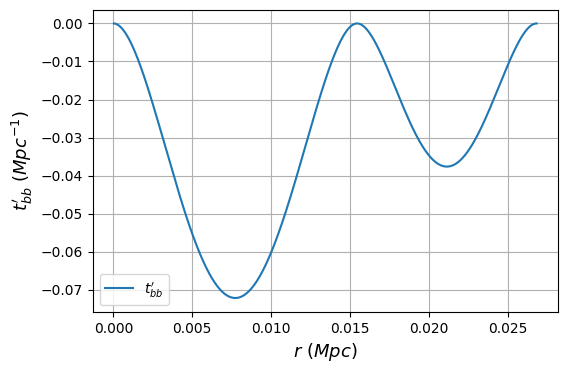

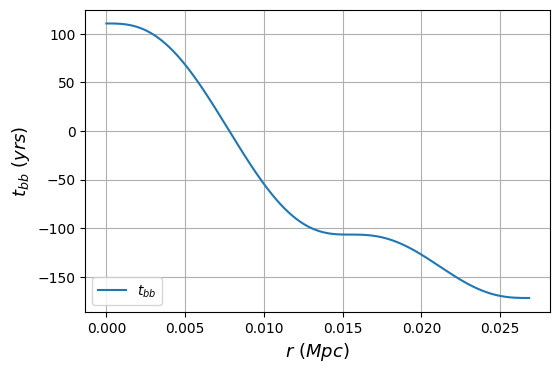

In [73]:
fig1 = plt.figure(1,dpi=100)
plt.plot(r1,tbbprim1,label=r'$t^{\prime}_{bb}$')
plt.legend(loc='lower left')
axes = plt.gca()
#axes.set_xlim([-1,70])
plt.xlabel('$r\ (Mpc)$',size='13')
plt.ylabel(r'$t^{\prime}_{bb}\ (Mpc^{-1})$',size='13')
plt.grid(True)

#plt.savefig('/Users/klesto92/Documents/TesisDoctorado/Tensor Bel-Robinson/GraficasSzekeresI/tbbprim.png',bbox_inches='tight',dpi=300)



fig2 = plt.figure(2,dpi=100)
plt.plot(r1,tbb2,label=r'$t_{bb}$')
plt.legend(loc='lower left')
axes = plt.gca()
#axes.set_xlim([-1,70])
plt.xlabel('$r\ (Mpc)$',size='13')
plt.ylabel(r'$t_{bb}\ (yrs)$',size='13')
plt.grid(True)

#plt.savefig('/Users/klesto92/Documents/TesisDoctorado/Tensor Bel-Robinson/GraficasSzekeresI/tbb.png',bbox_inches='tight',dpi=300)





In [55]:
#Hqtbb1/(HqSol[0,:,0])